Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 95.8MB/s]


C3 torch.Size([1, 512, 100, 100])
C4 torch.Size([1, 1024, 50, 50])
C5 torch.Size([1, 2048, 25, 25])


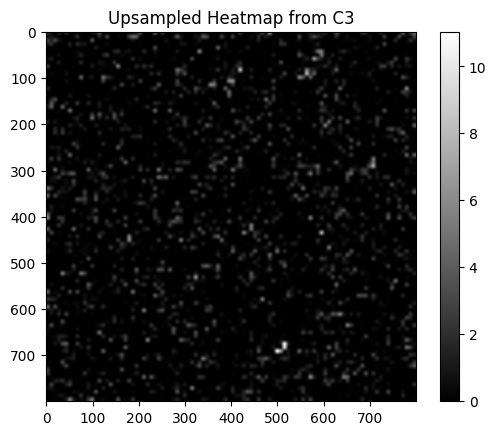

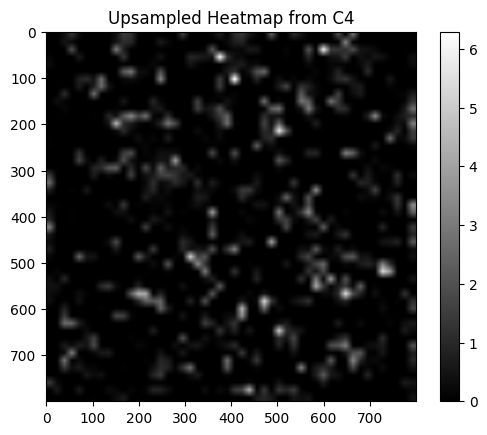

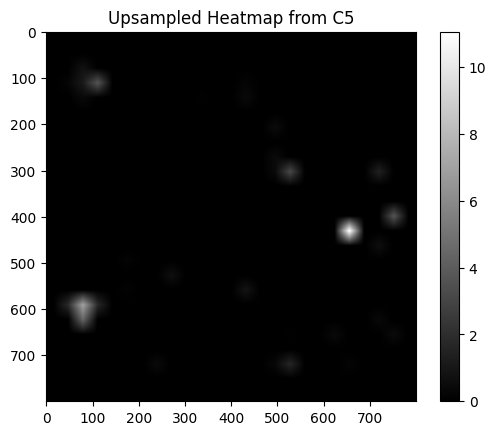

In [1]:
import torch
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


img_path = "/content/test_1.jpg"
img = Image.open(img_path).convert("RGB")

img_array = np.random.randint(0, 255, size=(800, 800, 3), dtype=np.uint8)
img = Image.fromarray(img_array).convert("RGB")


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((800, 800)),  # Thêm/Sửa: Đảm bảo kích thước thống nhất
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

x = transform(img).unsqueeze(0)

backbone = torchvision.models.resnet50(weights="DEFAULT")
nodes = {"layer2": "C3", "layer3": "C4", "layer4": "C5"}
extractor = create_feature_extractor(backbone, return_nodes=nodes)
with torch.no_grad():
    feats = extractor(x)

# In kích thước mỗi level (kết quả mong đợi: C3 [1,512,100,100], C4 [1,1024,50,50], C5 [1,2048,25,25] cho input 800x800)
for k, v in feats.items():
    print(k, v.shape)

# Hiển thị heatmap ngẫu nhiên cho multi-scale
from torch.nn.functional import interpolate
for k, v in feats.items():
    image_array = v[0, 10, :, :]  # Channel 10 ngẫu nhiên
    # Upsample về 800x800 để so sánh
    upsampled = interpolate(image_array.unsqueeze(0).unsqueeze(0), size=(800, 800), mode='bilinear', align_corners=False).squeeze().numpy()
    plt.imshow(upsampled, cmap='gray')
    plt.colorbar()
    plt.title(f"Upsampled Heatmap from {k}")
    plt.show()

Total anchors: (22500, 4)


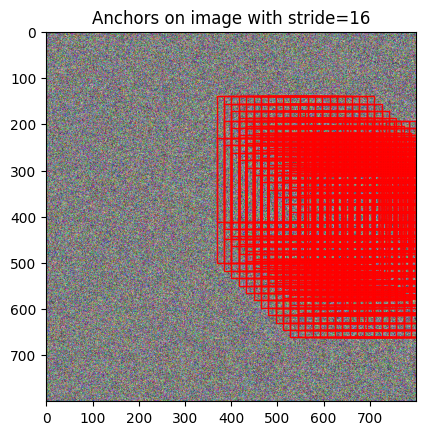

After NMS, kept: 100


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function từ demo
def generate_anchors(base_size=32, ratios=(0.5,1.0,2.0), scales=(8,16,32)):
    anchors = []
    for s in scales:
        area = (base_size * s) ** 2
        for r in ratios:
            w = np.sqrt(area / r)
            h = w * r
            anchors.append([-w/2, -h/2, w/2, h/2])
    return np.array(anchors, dtype=np.float32)

def shift_anchors(feat_h, feat_w, stride, base_anchors):
    shifts_x = np.arange(0, feat_w) * stride
    shifts_y = np.arange(0, feat_h) * stride
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shifts = np.stack([shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel()], axis=1)
    A = base_anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (base_anchors.reshape((1,A,4)) + shifts.reshape((K,1,4))).reshape(-1,4)
    return all_anchors

# Sửa: Stride tùy chọn, ví dụ 16 cho level P4 (feat 50x50 cho 800x800)
stride = 16
feat_h, feat_w = 50, 50

base_anchors = generate_anchors()
all_anchors = shift_anchors(feat_h, feat_w, stride, base_anchors)
print("Total anchors:", all_anchors.shape)  # ~22500 cho 50x50*9

# Ảnh
# img_path = "/content/test_1.jpg"  # Sửa thành ảnh thực
img_array = np.random.randint(0, 255, size=(800, 800, 3), dtype=np.uint8)
img = Image.fromarray(img_array).convert("RGB")

plt.imshow(img)
ax = plt.gca()

# Vẽ một số anchor quanh tâm để cảm nhận mật độ (vẽ hết sẽ dày đặc)
center = (25, 25)
for dy in range(-5,6):  # Mở rộng để thấy mật độ
    for dx in range(-5,6):
        start = ((center[0]+dy)*feat_w + (center[1]+dx)) * base_anchors.shape[0]
        for i in range(3):  # 3 anchors per cell
            idx = start + i
            if idx >= len(all_anchors): continue
            x1,y1,x2,y2 = all_anchors[idx]
            rect = plt.Rectangle((x1+y1, y1), x2-x1, y2-y1, fill=False, linewidth=1, edgecolor='r')
            ax.add_patch(rect)
plt.title("Anchors on image with stride={}".format(stride))
plt.show()

scores = np.random.rand(len(all_anchors))  # Ngẫu nhiên cho demo
boxes = torch.from_numpy(all_anchors.astype(np.float32))
from torchvision.ops import nms
# Fix: Cast scores to torch.float32
keep = nms(boxes, torch.from_numpy(scores).float(), iou_threshold=0.5)
keep = keep[:100]  # Giữ top 100
print("After NMS, kept:", len(keep))

In [7]:
import torch
import torchvision
from torchvision.ops import roi_align

feat = torch.randn(1, 256, 100, 100)  # [N,C,H,W], level P4 cho input 800x800

# Box trên ảnh gốc 800x800: Sửa box nếu cần
boxes_img = torch.tensor([[100,120,420,500]], dtype=torch.float32)

spatial_scale = 100/800  # Scale cho feat size / img size
rois = torch.cat([torch.zeros((boxes_img.size(0),1)), boxes_img], dim=1)

pooled = roi_align(feat, rois, output_size=(7,7), spatial_scale=spatial_scale, aligned=True)
print(pooled.shape)  # [1, 256, 7, 7]

# Để so RoI Pool vs Align, chạy với aligned=False (tương đương Pool)
pooled_pool = roi_align(feat, rois, output_size=(7,7), spatial_scale=spatial_scale, aligned=False)
print("RoI Pool shape: ", pooled_pool.shape)

torch.Size([1, 256, 7, 7])
RoI Pool shape:  torch.Size([1, 256, 7, 7])
